In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import sys

from aux import get_c_mean_p, get_c_spd, get_ang_diff
from mft import MFT

from disp import set_plot

In [2]:
# numeric params for computing MF quantities
DX = .05
X_MIN = -30
X_MAX = 200

mft = MFT(X_MIN, X_MAX, DX)

In [3]:
D = 64
N = 5000

mself = np.eye(D, dtype=bool)
mseq = np.diag(np.ones(D-1), -1).astype(bool)
mseq[0, -1] = True  # periodic

t_max = 400
t = np.arange(t_max)

A = np.linspace(0, 2*np.pi, D+1)[:-1]

In [4]:
# signal to be integrated
v = np.zeros(t_max)
v[(100 <= t)&(t < 150)] = 2.5
v[(250 <= t)&(t < 300)] = 1.25

## Fluctuation-driven network

Integration of neuromodulatory signal that changes weight variances.

In [5]:
# fluctuation-driven network
MU_J_FD = np.nan*np.zeros((D, D))
SGM_J_FD = np.nan*np.zeros((D, D))

MU_J_FD[mself] = 0
MU_J_FD[~mself] = 0
MU_J_FD[mseq] = 0

SGM_J_FD[mself] = 10
SGM_J_FD[~mself] = 0.1
SGM_J_FD[mseq] = 2.2

r_0_ref = .05*np.random.rand(D)
r_0_ref[:10] += 1
r_0_ref /= r_0_ref.sum()

r_0_int = .05*np.random.rand(D)
r_0_int[:10] += 1
r_0_int /= r_0_int.sum()

rs_fd_ref = np.nan*np.zeros((t_max, D))
rs_fd_ref[0, :] = r_0_ref

rs_fd_int = np.nan*np.zeros((t_max, D))
rs_fd_int[0, :] = r_0_int

for t_ in t[1:]:
    rs_fd_ref[t_, :] = mft.alph(rs_fd_ref[t_-1, :], u=0, v=0, D=D, mu_j=MU_J_FD, sgm_j=SGM_J_FD, N=N)
    
    sgm_j_fd = SGM_J_FD.copy()
    sgm_j_fd[mseq] += v[t_]
    
    rs_fd_int[t_, :] = mft.alph(rs_fd_int[t_-1, :], u=0, v=0, D=D, mu_j=MU_J_FD, sgm_j=sgm_j_fd, N=N)

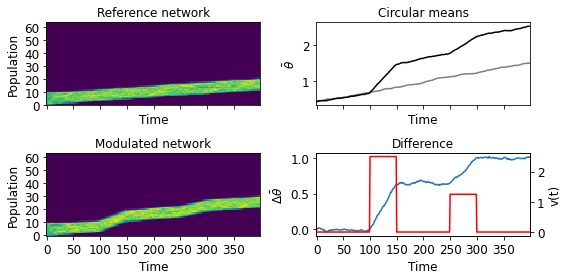

In [6]:
fig, axs = plt.subplots(2, 2, figsize=(8, 4), tight_layout=True, sharex=True)
axs[0, 0].matshow(rs_fd_ref.T, origin='lower')
axs[0, 0].set_aspect('auto')
axs[0, 0].xaxis.tick_bottom()
set_plot(axs[0, 0], x_label='Time', y_label='Population', title='Reference network')

axs[1, 0].matshow(rs_fd_int.T, origin='lower')
axs[1, 0].set_aspect('auto')
axs[1, 0].xaxis.tick_bottom()
set_plot(axs[1, 0], x_label='Time', y_label='Population', title='Modulated network')

c_mean_fd_refs = get_c_mean_p(A, rs_fd_ref)
c_mean_fd_ints = get_c_mean_p(A, rs_fd_int)

axs[0, 1].plot(t, c_mean_fd_refs, c='gray')
axs[0, 1].plot(t, c_mean_fd_ints, c='k')
set_plot(axs[0, 1], x_label='Time', y_label=r'$\bar{\theta}$', title='Circular means')

axs[1, 1].plot(t, get_ang_diff(c_mean_fd_refs, c_mean_fd_ints))
set_plot(axs[1, 1], x_label='Time', y_label=r'$\Delta \bar{\theta}$', title='Difference')

ax_twin = axs[1, 1].twinx()
ax_twin.plot(t, v, c='r')
set_plot(ax_twin, y_label='v(t)')